#### Imports

In [1]:
## import statements for the regression pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns


# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

# import scaling methods
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split

# import modeling methods
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from scipy import stats

# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

### Acquire 

Acquire the dataset from kaggle.com where each reservation represents a used bmw

link to dataset: https://www.kaggle.com/mysarahmadbhat/bmw-used-car-listing?select=bmw.csv

In [2]:
## acquire our data from our local csv

df = pd.read_csv('bmw.csv', index_col=0) ## reading our csv into a pandas dataframe

df.head() ## previewing our data

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
model,,,,,,,,
5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [3]:
## looking at our data shape 
df.shape

(10781, 8)

Looks like we have a good amount of observations let's look at some numerical statistics

In [4]:
## making a numerical statistics dataframe so we add a range by subtracting the min 
## from the max

stats = df.describe().T

stats['range'] = stats['max'] - stats['min'] 

stats ## displaying our numerical statistics

,count,mean,std,min,25%,50%,75%,max,range
year,10781.0,2017.078935,2.349038,1996.0,2016.0,2017.0,2019.0,2020.0,24.0
price,10781.0,22733.408867,11415.528189,1200.0,14950.0,20462.0,27940.0,123456.0,122256.0
mileage,10781.0,25496.986550,25143.192559,1.0,5529.0,18347.0,38206.0,214000.0,213999.0
tax,10781.0,131.702068,61.510755,0.0,135.0,145.0,145.0,580.0,580.0
mpg,10781.0,56.399035,31.336958,5.5,45.6,53.3,62.8,470.8,465.3
engineSize,10781.0,2.167767,0.552054,0.0,2.0,2.0,2.0,6.6,6.6


Now lets take a look at our data types for the columns and see if we have any null values that we will need to deal with in the prepare phase

In [5]:
## looking at our columns and their data types

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10781 entries,  5 Series to  X1
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          10781 non-null  int64  
 1   price         10781 non-null  int64  
 2   transmission  10781 non-null  object 
 3   mileage       10781 non-null  int64  
 4   fuelType      10781 non-null  object 
 5   tax           10781 non-null  int64  
 6   mpg           10781 non-null  float64
 7   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 758.0+ KB


Looks like we have correct datatypes for the numerical columns and we have 10781 entries and matching non-null values in all columns. 

Now lets look at value counts for the object columns.

In [6]:
## looking at certain object value counts

list = ['fuelType', 'transmission']

for x in list:
    print(f'Value Counts for {x}:\n')
    print(df[x].value_counts())
    print('--------------------')

Value Counts for fuelType:

Diesel      7027
Petrol      3417
Hybrid       298
Other         36
Electric       3
Name: fuelType, dtype: int64
--------------------
Value Counts for transmission:

Semi-Auto    4666
Automatic    3588
Manual       2527
Name: transmission, dtype: int64
--------------------


Looks like we have some rare cases of electric bmws. Knowing the electric car bmw has to offer is the i8 (very expensive car) we may able to use this to help predict higher priced cars.

Now lets look at continuous variable distributions in our dataset.

Distribution of year



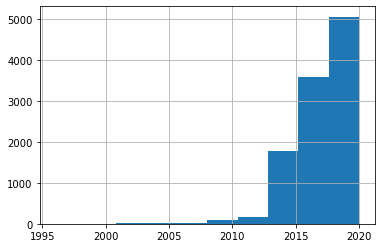

--------------------
Distribution of price



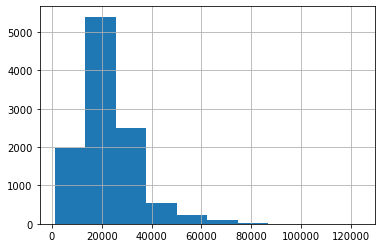

--------------------
Distribution of mileage



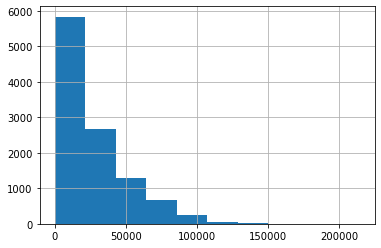

--------------------
Distribution of tax



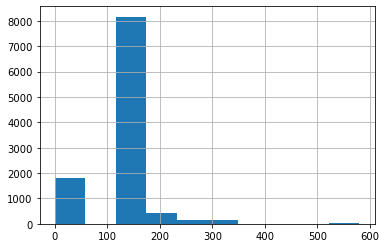

--------------------
Distribution of mpg



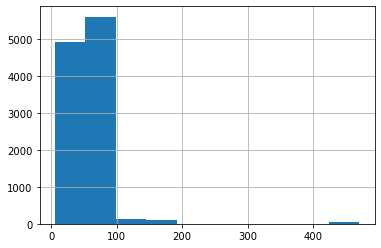

--------------------
Distribution of engineSize



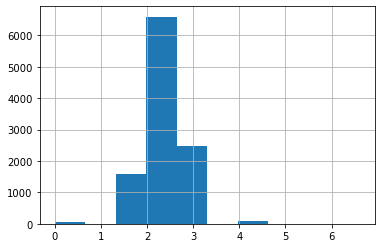

--------------------


In [7]:
## looking at our continuous variable distributions

stats = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']

for x in stats:
    print(f'Distribution of {x}\n')
    df[x].hist()
    plt.show()
    print('--------------------')

#### Distribution Takeaways

Year Manufactured:
 - Looks like the year of all the used BMWs ranges from 2000 to 2020 and the distribution is skewed to the right.
 
Price of Vehicle:
 - Looks the have a large range from 3,000 to 80,000 and the distributions is close to normal but has a tail to the left near the higher prices.
 
Mileage of Vehicle:
 - The mileage of the vehicles is skewed to the left and not normally distributed
 
Tax on Vehicle:
 - The tax of the vehicles is relatively normal but has some gaps in the histogram
 
Miles Per Gallon of Vehicle:
 - The miles per gallon of the vehicles seem to have an outlier around 400 those could be the electric cars filling that value at their miles per charge since they don't use gasoline.

Engine Size of Vehicle:
 - The engine size of the vehicles is normally distributed and is measured in Liters so the range is 0 to 4.8 it looks like.


### Prepare 

In repare we will look at null values and make sure there are no duplicate observations as well as do things like check for outliers and feature engineering to find the most impactful features for predicting the prices of used BMWs in the dataset.

In [8]:
def split_data(df):
    '''
    This function is designed to split out data for modeling into train, validate, and test 
    dataframes.
    
    It will also perform quality assurance checks on each dataframe to make sure the target 
    variable was correctcly stratified into each dataframe.
    '''
    
    ## splitting the data stratifying for out target variable is_fraud
    train_validate, test = train_test_split(df, test_size=.2, 
                                            random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                       random_state=123)
    
    print('Making Sure Our Shapes Look Good')
    print(f'Train: {train.shape}, Validate: {validate.shape}, Test: {test.shape}')
    
    return train, validate, test

In [9]:
## we already checked for null values by doing the df.info() and we saw there
## were none so will now check for duplicate observations

df.duplicated().sum() 

120

Looks like we have 120 duplicate observations that isn't too many compared to the 10 thousand observations in the dataframe.

In [10]:
## dropping the duplicates 

df = df.drop_duplicates()

In [11]:
## quality assurance check: making sure the duplicates have been dropped

df.duplicated().sum()

0

From previous experience string valued columns that have trailing and leading whitespace will cause problems when feature engineering, and exploring. So we will take care of this first before making new features for the dataset.

In [12]:
df = df.reset_index() ## we also are going to reset the index so that the model information
## is a useable column

In [13]:
## stripping trailing and leading whitespace from string valued columns just in case

df.model = df.model.str.strip()
df.fuelType = df.fuelType.str.strip()
df.transmission = df.transmission.str.strip()

In [14]:
## looking at our dataframe 

df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


#### Feature Engineering

In [15]:
## Looking at the fuel type values so I can one hot encode different columns for each fuel
## type

df.fuelType.value_counts()

Diesel      6985
Petrol      3340
Hybrid       297
Other         36
Electric       3
Name: fuelType, dtype: int64

In [21]:
## using one hot encoding to get dummy categorical columns for diesel, electric, and hybrid
## fuel types

df['is_diesel'] = np.where(df.fuelType == 'Diesel', 1, 0)
df['is_electric'] = np.where(df.fuelType == 'Electric', 1, 0)
df['is_hybrid'] = np.where(df.fuelType == 'Hybrid', 1, 0)


Now that we have made our categorical columns let's check their values to make sure they match the value counts above and were done correctly.

In [24]:
## looking at certain object value counts

list = ['is_diesel', 'is_electric', 'is_hybrid']

for x in list:
    print(f'Value Counts for {x}:\n')
    print(df[x].value_counts())
    print('--------------------')

Value Counts for is_diesel:

1    6985
0    3676
Name: is_diesel, dtype: int64
--------------------
Value Counts for is_electric:

0    10658
1        3
Name: is_electric, dtype: int64
--------------------
Value Counts for is_hybrid:

0    10364
1      297
Name: is_hybrid, dtype: int64
--------------------


These all look correct according to the original value counts of the fuel type column

In [22]:
df.transmission.value_counts()

Semi-Auto    4634
Automatic    3542
Manual       2485
Name: transmission, dtype: int64

In [23]:
## using one hot encoding to get dummy categorical columns for manual, automatic, 
## and semi automatic transmission types


df['is_manual'] = np.where(df.transmission == 'Manual', 1, 0)
df['is_semiauto'] = np.where(df.transmission == 'Semi-Auto', 1, 0)
df['is_automatic'] = np.where(df.transmission == 'Automatic', 1, 0)

Now that we have made our categorical columns let's check their values to make sure they match the value counts above and were done correctly.

In [25]:
## looking at certain object value counts

list = ['is_manual', 'is_semiauto', 'is_automatic']

for x in list:
    print(f'Value Counts for {x}:\n')
    print(df[x].value_counts())
    print('--------------------')

Value Counts for is_manual:

0    8176
1    2485
Name: is_manual, dtype: int64
--------------------
Value Counts for is_semiauto:

0    6027
1    4634
Name: is_semiauto, dtype: int64
--------------------
Value Counts for is_automatic:

0    7119
1    3542
Name: is_automatic, dtype: int64
--------------------


These all correspond to the original value counts for the transmission type and look correct lets continue with splitting our data.

In [26]:
## using our data split function to split into train validate, & test dataframes

train, validate, test = split_data(df)

Making Sure Our Shapes Look Good
Train: (5969, 15), Validate: (2559, 15), Test: (2133, 15)


After splitting the data the datashapes look consistent 

In [27]:
train.head() ## previewing our train df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,is_diesel,is_electric,is_hybrid,is_manual,is_semiauto,is_automatic
6239,1 Series,2017,16722,Semi-Auto,9063,Petrol,145,55.5,1.5,0,0,0,0,1,0
1575,X6,2018,37900,Semi-Auto,11500,Diesel,150,40.9,3.0,1,0,0,0,1,0
9531,X3,2015,13999,Manual,51715,Diesel,160,52.3,2.0,1,0,0,1,0,0
7508,1 Series,2017,15490,Automatic,26000,Diesel,125,61.4,2.0,1,0,0,0,0,1
9816,1 Series,2016,8999,Manual,94300,Diesel,0,83.1,1.5,1,0,0,1,0,0
